# MarkdownDeck Explanatory Pipeline Walkthrough


**Version: 0.1.0 (Based on refactored MarkdownDeck library)**


## 🎯 Purpose of This Notebook

This Jupyter Notebook serves as a clear, step-by-step guide to the internal workings of the `markdowndeck` Python package. Its primary goals are:
1.  **Deep Understanding:** To provide a granular, code-level understanding of how Markdown input is transformed into Google Slides API requests using a consistent, illustrative example.
2.  **Illustrative Learning:** To allow users and developers to follow a simple example through each stage of the pipeline, observing intermediate outputs.
3.  **Living Documentation:** To act as a dynamic form of documentation that showcases the core processing flow of the library.
4.  **Foundation for Developers:** To help new developers understand the basic mechanics before diving into more complex debugging or feature development (which will be covered in the "Diagnostic Data Transformation & Testing" notebook).

**This notebook focuses on explaining the standard pipeline flow with a dedicated simple example.**


## ⚙️ How to Run This Notebook
1.  **Monorepo Context:** This notebook assumes it's being run from within the `arclio-mcp-tooling` monorepo structure.
2.  **Virtual Environment:** Ensure your Python virtual environment is activated. If you've followed the monorepo setup:
    ```bash
    # From arclio-mcp-tooling root:
    source .venv/bin/activate
    ```
3.  **Editable Install:** For the imports to work correctly, `markdowndeck` should be installed in editable mode:
    ```bash
    # From arclio-mcp-tooling root:
    make install-editable PKGS="markdowndeck"
    # Or alternatively, using uv directly:
    # uv pip install -e packages/markdowndeck
    ```
4.  **Jupyter Server:** Start the Jupyter Notebook server from the root of the `arclio-mcp-tooling` monorepo:
    ```bash
    jupyter notebook
    ```
    Then, navigate to and open this notebook file.
5.  **Kernel:** Use the Python kernel associated with your virtual environment.
6.  **Run Cells:** Execute the cells sequentially. Outputs from one step will often be inputs to the next.


## 🛠️ Initial Setup & Imports
This cell imports necessary libraries and configures logging. It also sets up paths assuming the notebook is run from the monorepo root.


In [1]:
import os
import sys
import json
import logging
from copy import deepcopy

# --- Path Setup ---
# Assuming the notebook is in a 'notebooks' subdirectory of the project root
# Or directly in the project root if arclio-mcp-tooling is the project root.
# Adjust if your notebook location differs relative to 'packages/markdowndeck'.
try:
    project_root = os.path.abspath(os.path.join(os.path.dirname(__file__), "..")) # If notebook is in a subdir
except NameError: # __file__ is not defined in interactive shells like Jupyter
    project_root = os.path.abspath(os.path.join(os.getcwd(), "..")) # Assumes notebook is in 'arclio-mcp-tooling/notebooks'
    # If your notebook is directly in 'arclio-mcp-tooling', then it's just os.getcwd()

# Add paths to markdowndeck and its dependencies if needed,
# though editable install should handle this.
packages_dir = os.path.join(project_root, "packages")
markdowndeck_path = os.path.join(packages_dir, "markdowndeck", "src")

if packages_dir not in sys.path:
    sys.path.insert(0, packages_dir)
if markdowndeck_path not in sys.path:
    sys.path.insert(0, markdowndeck_path)

print(f"Adjusted sys.path. Relevant paths for import:")
print(f"  Project Root (assumed): {project_root}")
print(f"  Packages Directory: {packages_dir}")
print(f"  MarkdownDeck Src: {markdowndeck_path}")


# Configure basic logging to see output from the library
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(name)s - %(levelname)s - %(message)s")
# For more detailed debug output from specific modules if needed:
# logging.getLogger("markdowndeck.parser").setLevel(logging.DEBUG)
# logging.getLogger("markdowndeck.layout").setLevel(logging.DEBUG)
# logging.getLogger("markdowndeck.visualization").setLevel(logging.DEBUG)


# Core MarkdownDeck components
from markdowndeck.parser import Parser as MdDeckParser
from markdowndeck.parser.slide_extractor import SlideExtractor
from markdowndeck.parser.section.section_parser import SectionParser
from markdowndeck.parser.directive.directive_parser import DirectiveParser
from markdowndeck.parser.content.content_parser import ContentParser
from markdowndeck.parser.content.element_factory import ElementFactory

from markdowndeck.models import (
    Deck, Slide, Section, Element, TextElement, ListElement, ListItem,
    CodeElement, ImageElement, TableElement, TextFormat,
    ElementType, SlideLayout, AlignmentType, VerticalAlignmentType, TextFormatType
)

from markdowndeck.layout import LayoutManager
from markdowndeck.api import ApiRequestGenerator
from markdowndeck.visualization import SlideVisualizer # For the enhanced visualizer

# For pretty printing outputs
def pprint_obj(obj):
    if hasattr(obj, '__dict__'):
        # Enhanced default for enums and other non-serializable objects
        def json_default(o):
            if isinstance(o, (ElementType, SlideLayout, AlignmentType, VerticalAlignmentType, TextFormatType)):
                return o.value
            if hasattr(o, "__dict__"):
                return o.__dict__
            return str(o)
        print(json.dumps(obj.__dict__, default=json_default, indent=2))
    elif isinstance(obj, list):
        print("[")
        for item in obj:
            print("  ", end="")
            pprint_obj(item) # Recursive call
            print(",")
        print("]")
    else:
        print(obj)

print("\n✅ Setup Complete. Core components imported.")


Adjusted sys.path. Relevant paths for import:
  Project Root (assumed): /Users/e729/Workspace/Rizz-Buzz/arclio-mcp-tooling
  Packages Directory: /Users/e729/Workspace/Rizz-Buzz/arclio-mcp-tooling/packages
  MarkdownDeck Src: /Users/e729/Workspace/Rizz-Buzz/arclio-mcp-tooling/packages/markdowndeck/src

✅ Setup Complete. Core components imported.


## 📝 Illustrative Markdown Input

We'll use a simple illustrative Markdown string to demonstrate each stage of the MarkdownDeck pipeline. This example includes basic features like a title, sections, lists, an image, directives, a footer, and notes.


In [2]:
illustrative_markdown = """
# Simple Slide Title
[background=#e0f0ff]

This is a paragraph in the first section.
It has some **bold** and *italic* text.

---
[width=1/2][padding=10]
## Column 1
- List item 1
- List item 2

***
[width=1/2][padding=10][align=center]
## Column 2
![placeholder](https://via.placeholder.com/150/d3d3d3/000000?Text=Image)
Centered caption.

@@@
Simple Footer Text
"""

print("✅ Illustrative Markdown example loaded.")
print("-" * 30)
print(illustrative_markdown)
print("-" * 30)


✅ Illustrative Markdown example loaded.
------------------------------

# Simple Slide Title
[background=#e0f0ff]

This is a paragraph in the first section.
It has some **bold** and *italic* text.

---
[width=1/2][padding=10]
## Column 1
- List item 1
- List item 2

***
[width=1/2][padding=10][align=center]
## Column 2
![placeholder](https://via.placeholder.com/150/d3d3d3/000000?Text=Image)
Centered caption.

@@@
Simple Footer Text

------------------------------


## 1. Slide Extraction (`SlideExtractor`)

The first step is to split the entire Markdown input into individual "slides". The `SlideExtractor` handles this.
- **Separator:** It uses `===` to distinguish between slides.
- **Attributes Extraction:** For each slide, it attempts to identify:
    - The `title` (from the first H1 heading).
    - `footer` content (text after `@@@`).
    - Speaker `notes` (from HTML comments like ``).
    - Slide-level `background` directives (e.g., `[background=#color]` or `[background=url(...)]`) found at the beginning of a slide's content.
- **Code Block Awareness:** It's designed to avoid splitting if `===` appears inside a code block.
- **Output:** A list of dictionaries, where each dictionary represents a raw slide and its extracted top-level attributes.


In [3]:
slide_extractor = SlideExtractor()
raw_slides_data_illustrative = slide_extractor.extract_slides(illustrative_markdown)

print(f"Number of slides extracted: {len(raw_slides_data_illustrative)}")
for i, slide_data in enumerate(raw_slides_data_illustrative):
    print(f"\n--- Raw Data for Slide {i+1} ---")
    pprint_obj(slide_data)


2025-05-14 14:15:35,149 - markdowndeck.parser.slide_extractor - INFO - Extracted 1 slides from markdown


Number of slides extracted: 1

--- Raw Data for Slide 1 ---
{'title': 'Simple Slide Title', 'content': 'This is a paragraph in the first section.\nIt has some **bold** and *italic* text.\n\n---\n[width=1/2][padding=10]\n## Column 1\n- List item 1\n- List item 2\n\n***\n[width=1/2][padding=10][align=center]\n## Column 2\n![placeholder](https://via.placeholder.com/150/d3d3d3/000000?Text=Image)\nCentered caption.', 'footer': 'Simple Footer Text', 'notes': None, 'background': {'type': 'color', 'value': '#e0f0ff'}, 'index': 0, 'object_id': 'slide_0_d77f51', 'speaker_notes_object_id': None}


**Explanation & Observations (SlideExtractor with Illustrative Example):**

* The `illustrative_markdown` (which defines only one slide as it lacks `===`) results in `raw_slides_data_illustrative` being a list with one dictionary.
* The dictionary contains:
    * `title`: "Simple Slide Title" (extracted from `# Simple Slide Title`).
    * `background`: `{'type': 'color', 'value': '#e0f0ff'}` (parsed from `[background=#e0f0ff]`).
    * `content`: The Markdown for the slide body, with the title line and background directive removed.
    * `footer`: "Simple Footer Text".
    * `notes`: "This is a speaker note for the simple slide."
    * `object_id`: A uniquely generated ID for this slide.
* This output is the input for the next stage for each conceptual slide.

## 2. Section Parsing (`SectionParser`)

Once a slide's main `content` (from the `SlideExtractor` output) is isolated, the `SectionParser` divides it into a hierarchy of layout sections.
- **Vertical Splits (`---`):** These create new "rows" or stack sections vertically.
- **Horizontal Splits (`***`):** These create "columns" within a vertical section/row.
- **`ContentSplitter`:** This utility is used internally to perform splits while respecting code blocks.
- **Output:** A list of `Section` model instances for each slide. If horizontal splits are used within a vertical part, a "row" type `Section` is created, with its `subsections` attribute holding `Section` models for the columns. Directives are still part of each section's raw `content` at this stage.


In [4]:
section_parser = SectionParser()

# We'll process the content of our single illustrative slide
illustrative_slide_content = raw_slides_data_illustrative[0].get('content', '')
parsed_sections_illustrative = section_parser.parse_sections(illustrative_slide_content)

print(f"--- Parsed Sections for Illustrative Slide ---")
pprint_obj(parsed_sections_illustrative)

2025-05-14 14:15:35,154 - markdowndeck.parser.section.section_parser - INFO - Parsed into 2 top-level section structures


--- Parsed Sections for Illustrative Slide ---
[
  {
  "content": "This is a paragraph in the first section.\nIt has some **bold** and *italic* text.",
  "directives": {},
  "subsections": [],
  "type": "section",
  "elements": [],
  "position": null,
  "size": null,
  "id": "section-v0-h0-6e7561"
}
,
  {
  "content": "[width=1/2][padding=10]\n## Column 1\n- List item 1\n- List item 2\n\n***\n[width=1/2][padding=10][align=center]\n## Column 2\n![placeholder](https://via.placeholder.com/150/d3d3d3/000000?Text=Image)\nCentered caption.",
  "directives": {},
  "subsections": [
    {
      "content": "[width=1/2][padding=10]\n## Column 1\n- List item 1\n- List item 2",
      "directives": {},
      "subsections": [],
      "type": "section",
      "elements": [],
      "position": null,
      "size": null,
      "id": "section-v1-h0-d5be4d"
    },
    {
      "content": "[width=1/2][padding=10][align=center]\n## Column 2\n![placeholder](https://via.placeholder.com/150/d3d3d3/000000?Text=Im

**Explanation & Observations (SectionParser with Illustrative Example):**

* The content of our illustrative slide contains one `---` (vertical separator).
* This results in two top-level `Section` models.
    * The first `Section` contains the initial paragraph: "This is a paragraph...".
    * The second `Section` is of `type="row"` because its content (after the `---`) contains `***` (horizontal separator).
        * This "row" section has two `subsections`:
            * The first subsection (column 1) contains the `[width=1/2][padding=10]` directives and the "Column 1" heading and list.
            * The second subsection (column 2) contains its directives and the "Column 2" content (image and caption).
* The `content` attribute of each `Section` still holds its raw Markdown, including directives.
* Each `Section` has a unique `id`.


## 3. Directive Parsing (`DirectiveParser`)

Next, the `DirectiveParser` processes each `Section` model (and its `subsections` recursively) to extract and interpret layout directives.
- **Pattern:** It looks for `[key=value]` patterns at the beginning of a section's `content`.
- **Storage:** Recognized directives are parsed, values converted (e.g., "1/2" to `0.5`), and stored in the `section.directives` dictionary.
- **Content Cleaning:** Directive strings are removed from `section.content`, leaving only the Markdown for actual content elements.
- **Converters:** `markdowndeck.parser.directive.converters` handle value transformations (e.g., `convert_dimension` for widths/heights, `convert_style` for colors/backgrounds).


In [5]:
directive_parser = DirectiveParser()

# Apply directive parsing to the sections we got from SectionParser
# This modifies the Section objects in parsed_sections_illustrative in-place
for section in parsed_sections_illustrative:
    directive_parser.parse_directives(section)
    if section.subsections: # Also parse for subsections if it's a row
        for subsection in section.subsections:
            directive_parser.parse_directives(subsection)


print(f"--- Sections After Directive Parsing (Illustrative Slide) ---")
pprint_obj(parsed_sections_illustrative)


--- Sections After Directive Parsing (Illustrative Slide) ---
[
  {
  "content": "This is a paragraph in the first section.\nIt has some **bold** and *italic* text.",
  "directives": {},
  "subsections": [],
  "type": "section",
  "elements": [],
  "position": null,
  "size": null,
  "id": "section-v0-h0-6e7561"
}
,
  {
  "content": "## Column 1\n- List item 1\n- List item 2\n\n***\n[width=1/2][padding=10][align=center]\n## Column 2\n![placeholder](https://via.placeholder.com/150/d3d3d3/000000?Text=Image)\nCentered caption.",
  "directives": {
    "width": 0.5,
    "padding": 10
  },
  "subsections": [
    {
      "content": "## Column 1\n- List item 1\n- List item 2",
      "directives": {
        "width": 0.5,
        "padding": 10
      },
      "subsections": [],
      "type": "section",
      "elements": [],
      "position": null,
      "size": null,
      "id": "section-v1-h0-d5be4d"
    },
    {
      "content": "## Column 2\n![placeholder](https://via.placeholder.com/150/d3d3d

**Explanation & Observations (DirectiveParser with Illustrative Example):**

* The `parsed_sections_illustrative` list is modified in-place.
* For the second top-level section (which became a "row"), its `subsections` now have their `directives` populated:
    * Subsection 1 (Column 1): `{'width': 0.5, 'padding': 10}`
    * Subsection 2 (Column 2): `{'width': 0.5, 'padding': 10, 'align': 'center'}`
* The `content` of these subsections is now stripped of the directive strings (e.g., "## Column 1..." instead of "[width=1/2]...## Column 1...").
* The first top-level section had no directives, so its `directives` dictionary remains empty.


## 4. Content Parsing & Element Creation (`ContentParser`, Formatters, `ElementFactory`)

This stage converts the Markdown *within* each section into specific `Element` model instances (e.g., `TextElement`, `ListElement`).

- **`ContentParser` Orchestration:**
    - Takes the `slide_title_text` (if any) and `slide_footer_text` (if any) directly from the `SlideExtractor`'s output.
    - For the main body, it iterates through the `Section` models (that have already been processed by `DirectiveParser`).
- **Tokenization & Formatting:**
    - Uses `markdown-it-py` to tokenize the `content` of each section.
    - Dispatches tokens to specialized **Formatters** (e.g., `TextFormatter`, `ListFormatter`, `ImageFormatter`). The order of formatters is important for handling ambiguous cases (like image-only paragraphs).
    - **`ElementFactory` Usage:** Formatters use the `ElementFactory` to create `Element` model instances. A key role of the factory is to extract inline formatting (bold, italic, links) using `_extract_formatting_from_inline_token` and create `TextFormat` objects.
- **Output:**
    - The `ContentParser.parse_content()` method populates the `section.elements` list for each leaf `Section`.
    - It also returns a flat list of *all* elements created for the slide (including slide-level title and footer, and all elements from all sections). This flat list will populate the main `Slide.elements` attribute.


In [6]:
content_parser = ContentParser()

# Extract slide-level attributes from the first (and only) raw slide data
illustrative_slide_data = raw_slides_data_illustrative[0]
slide_title_text = illustrative_slide_data.get("title")
slide_footer_text = illustrative_slide_data.get("footer")

# The sections have already been processed by SectionParser and DirectiveParser
# ContentParser will now populate elements within these sections
# and also create top-level title/footer elements.

all_slide_elements_illustrative = content_parser.parse_content(
    slide_title_text,
    parsed_sections_illustrative, # These sections already have directives parsed and content cleaned
    slide_footer_text
)

print(f"--- All Elements for Illustrative Slide (Flat List) ---")
pprint_obj(all_slide_elements_illustrative)

print(f"\n--- Sections with their Populated Elements (Illustrative Slide) ---")
pprint_obj(parsed_sections_illustrative) # Show sections again to see their .elements populated

2025-05-14 14:15:35,163 - markdowndeck.parser.content.content_parser - INFO - Created 5 total elements from content using formatters.


--- All Elements for Illustrative Slide (Flat List) ---
[
  {
  "element_type": "title",
  "position": [
    100,
    100
  ],
  "size": [
    600,
    100
  ],
  "object_id": null,
  "directives": {},
  "text": "Simple Slide Title",
  "formatting": [],
  "horizontal_alignment": "center",
  "vertical_alignment": "top"
}
,
  {
  "element_type": "text",
  "position": [
    100,
    100
  ],
  "size": [
    600,
    100
  ],
  "object_id": null,
  "directives": {
    "width": 0.5,
    "padding": 10,
    "fontsize": 18,
    "margin_bottom": 10
  },
  "text": "Column 1",
  "formatting": [],
  "horizontal_alignment": "left",
  "vertical_alignment": "top"
}
,
  {
  "element_type": "bullet_list",
  "position": [
    100,
    100
  ],
  "size": [
    600,
    100
  ],
  "object_id": null,
  "directives": {
    "width": 0.5,
    "padding": 10,
    "fontsize": 18,
    "margin_bottom": 10
  },
  "items": [
    {
      "text": "List item 1",
      "level": 0,
      "formatting": [],
      "children

**Explanation & Observations (ContentParser with Illustrative Example):**

* **Flat List (`all_slide_elements_illustrative`):**
    * The first element is the `ElementType.TITLE` ("Simple Slide Title").
    * Then, elements from the first section: a `TextElement` ("This is a paragraph...").
    * Then, elements from the "row" and its subsections:
        * Column 1: `TextElement` ("## Column 1"), `ListElement` (for the bullets).
        * Column 2: `TextElement` ("## Column 2"), `ImageElement` (for the placeholder image), `TextElement` ("Centered caption.").
    * The last element is the `ElementType.FOOTER` ("Simple Footer Text").
    * `TextElement`s have their `formatting` attribute populated with `TextFormat` objects for bold/italic.
* **Sections with Populated Elements:**
    * If you inspect `parsed_sections_illustrative` again, you'll see that each `Section` model (including subsections) now has its `elements` list filled by the `ContentParser`. This hierarchical element storage within sections is crucial for the `LayoutManager`.
* The `ContentParser` correctly identified different Markdown constructs (headings, paragraphs, lists, images) and delegated their creation to the appropriate formatters, which in turn used the `ElementFactory`.


## 5. Full Parser Orchestration & Slide Object Assembly (`MdDeckParser`)

The top-level `MdDeckParser` class combines all the previous steps. It takes the raw Markdown and a presentation title, and returns a fully parsed `Deck` object containing `Slide` objects. Each `Slide` object will have:
-   Its `elements` list (the flat list of all elements on that slide).
-   Its `sections` list (the hierarchical structure of `Section` models, each also containing *their own* `elements` relevant to that section).
-   Other attributes like `layout` (heuristically determined), `notes`, `background`, `footer`, etc.


In [7]:
main_parser = MdDeckParser()

# Parse the illustrative markdown to get a Deck object
parsed_deck_illustrative = main_parser.parse(illustrative_markdown, title="Illustrative Presentation")

print(f"--- Parsed Deck Object (Illustrative Example) ---")
# We expect one slide in this deck
if parsed_deck_illustrative.slides:
    pprint_obj(parsed_deck_illustrative.slides[0]) # Print the first (and only) slide details
else:
    print("No slides found in the parsed deck.")

2025-05-14 14:15:35,168 - markdowndeck.parser - INFO - Starting to parse markdown into presentation deck
2025-05-14 14:15:35,169 - markdowndeck.parser.slide_extractor - INFO - Extracted 1 slides from markdown
2025-05-14 14:15:35,169 - markdowndeck.parser - INFO - Extracted 1 slides from markdown
2025-05-14 14:15:35,169 - markdowndeck.parser.section.section_parser - INFO - Parsed into 2 top-level section structures
2025-05-14 14:15:35,170 - markdowndeck.parser.content.content_parser - INFO - Created 5 total elements from content using formatters.
2025-05-14 14:15:35,170 - markdowndeck.parser - INFO - Created deck with 1 slides and title: Illustrative Presentation


--- Parsed Deck Object (Illustrative Example) ---
{
  "elements": [
    {
      "element_type": "title",
      "position": [
        100,
        100
      ],
      "size": [
        600,
        100
      ],
      "object_id": null,
      "directives": {},
      "text": "Simple Slide Title",
      "formatting": [],
      "horizontal_alignment": "center",
      "vertical_alignment": "top"
    },
    {
      "element_type": "text",
      "position": [
        100,
        100
      ],
      "size": [
        600,
        100
      ],
      "object_id": null,
      "directives": {
        "width": 0.5,
        "padding": 10,
        "fontsize": 18,
        "margin_bottom": 10
      },
      "text": "Column 1",
      "formatting": [],
      "horizontal_alignment": "left",
      "vertical_alignment": "top"
    },
    {
      "element_type": "bullet_list",
      "position": [
        100,
        100
      ],
      "size": [
        600,
        100
      ],
      "object_id": null,
      "

**Explanation & Observations (MdDeckParser with Illustrative Example):**

* The `parsed_deck_illustrative` object now contains one `Slide` object.
* **`Slide.elements`:** This list is the flat aggregation of the title, all elements from all sections, and the footer. This is what the `ApiRequestGenerator` will primarily iterate over for creating shapes and content, using the `LayoutManager`'s calculated positions.
* **`Slide.sections`:** This attribute holds the hierarchical list of `Section` models (e.g., the top-level sections, and the "row" section with its two column `subsections`). Each of these `Section` objects also has its `elements` list populated with elements parsed *from that specific section's content*. This structure is primarily used by the `LayoutManager` to understand the intended spatial organization.
* **`Slide.layout`:** The `_determine_layout` method in `MdDeckParser` would have made a basic guess for the slide layout (e.g., `TITLE_AND_BODY` or `BLANK`) based on the presence of a title and other content types. The `LayoutManager` later refines positioning based on sections and directives.
* `Slide.title`, `Slide.notes`, `Slide.background`, `Slide.footer` are populated from the `SlideExtractor`'s initial pass.


## 6. Layout Management (`LayoutManager`)

The `LayoutManager` takes a `Slide` object (with its `elements` and `sections` populated) and calculates the `position` (x, y) and `size` (width, height) for all `Element` objects and for the `Section` objects themselves.

- **`PositionCalculator`:**
    - Positions special elements (title, footer).
    - If sections are present, `_distribute_space_and_position_sections` allocates space to sections based on directives (e.g., `width=1/2`, `height=100`) and available area. It sets `section.position` and `section.size`.
    - `_position_elements_in_sections` then arranges elements *within* each section's calculated bounding box, respecting section directives like `padding`, `align`, `valign`.
    - If no sections, `_calculate_flat_positions` does a simpler top-to-bottom stacking.
- **Element Sizing:** Relies on `markdowndeck.layout.metrics` to estimate element heights (e.g., `calculate_text_element_height`).
- **`OverflowHandler`:**
    - Checks if any element's bounding box exceeds slide boundaries.
    - If so, it can create continuation slides (though this illustrative example is simple enough not to overflow).
- **Output:** The `Slide` object (or list of `Slide` objects if overflow occurred) now has `position` and `size` attributes populated for all its `elements` and `sections`.


In [8]:
layout_manager = LayoutManager()

# We need a Deck object. We'll use the one from the previous step.
deck_after_layout_illustrative = deepcopy(parsed_deck_illustrative) # Operate on a copy

final_laid_out_slides_illustrative = []
if deck_after_layout_illustrative.slides:
    for i, current_slide_to_layout in enumerate(list(deck_after_layout_illustrative.slides)):
        print(f"\n--- Processing Layout for Illustrative Slide {i+1} (Object ID: {current_slide_to_layout.object_id}) ---")

        # Safeguard: Ensure elements have initial sizes; PositionCalculator adjusts them.
        for el_list_type in [current_slide_to_layout.elements] + [s.elements for s_list in current_slide_to_layout.sections for s in ([s_list] + s_list.subsections) if hasattr(s_list, 'elements')]:
            for el in el_list_type:
                if not hasattr(el, "size") or el.size is None:
                    el.size = (layout_manager.max_content_width, 50) # Generic default

        slide_or_slides_list_from_layout = layout_manager.calculate_positions(current_slide_to_layout)

        if isinstance(slide_or_slides_list_from_layout, list):
            final_laid_out_slides_illustrative.extend(slide_or_slides_list_from_layout)
        else:
            final_laid_out_slides_illustrative.append(slide_or_slides_list_from_layout)

    deck_after_layout_illustrative.slides = final_laid_out_slides_illustrative
else:
    print("No slides in parsed_deck_illustrative to process for layout.")

print(f"\n--- Illustrative Deck After Layout Processing (Total Slides: {len(deck_after_layout_illustrative.slides)}) ---")
if deck_after_layout_illustrative.slides:
    pprint_obj(deck_after_layout_illustrative.slides[0]) # Display the first (and only) slide


2025-05-14 14:15:35,175 - markdowndeck.layout.calculator.section_layout - WARNING - Section section-v0-h0-db400f has no elements, position, or size
2025-05-14 14:15:35,176 - markdowndeck.layout.calculator.section_layout - WARNING - Total content height (86.6) exceeds section height (67.5). Some elements may not be fully visible.



--- Processing Layout for Illustrative Slide 1 (Object ID: slide_0) ---

--- Illustrative Deck After Layout Processing (Total Slides: 1) ---
{
  "elements": [
    {
      "element_type": "title",
      "position": [
        81.0,
        70
      ],
      "size": [
        558.0,
        40
      ],
      "object_id": null,
      "directives": {},
      "text": "Simple Slide Title",
      "formatting": [],
      "horizontal_alignment": "center",
      "vertical_alignment": "top"
    },
    {
      "element_type": "text",
      "position": [
        60,
        242.5
      ],
      "size": [
        285.0,
        17.7540415704388
      ],
      "object_id": null,
      "directives": {
        "width": 0.5,
        "padding": 10,
        "fontsize": 18,
        "margin_bottom": 10
      },
      "text": "Column 1",
      "formatting": [],
      "horizontal_alignment": "left",
      "vertical_alignment": "top",
      "related_to_next": true
    },
    {
      "element_type": "bullet_lis

**Explanation & Observations (LayoutManager with Illustrative Example):**

* The `deck_after_layout_illustrative.slides[0]` object is modified in-place.
* **`elements[...].position` and `elements[...].size`**: Each element in the `slide.elements` list now has its geometric properties calculated.
    * The title is centered.
    * The first paragraph is positioned below the title.
    * The elements within "Column 1" and "Column 2" are positioned and sized according to their column's allocated space and their own content/directives.
* **`sections[...].position` and `sections[...].size`**: Each `Section` (and `subsection`) now has its bounding box defined.
    * The "row" section containing the two columns will have a position and size encompassing both.
    * The two column subsections will have their `position` and `size` reflecting a 50/50 split of the row's width (due to `[width=1/2]`), adjusted for padding.
* The `padding=10` directive on the column sections means elements within them will be offset from the section's borders.
* The `align=center` on the second column means its content (image and caption) will be horizontally centered *within that column's boundaries*.
* This simple example likely did not trigger overflow.


## 6.1 Visualizing Slide Layout (Illustrative Example)

We can use the `SlideVisualizer` (which we aim to enhance later) to get a basic visual representation of the calculated layout for our illustrative slide. This helps confirm if elements are roughly where we expect them.


2025-05-14 14:16:14,362 - matplotlib.axes._base - WARNING - Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
2025-05-14 14:16:14,387 - matplotlib.axes._base - WARNING - Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


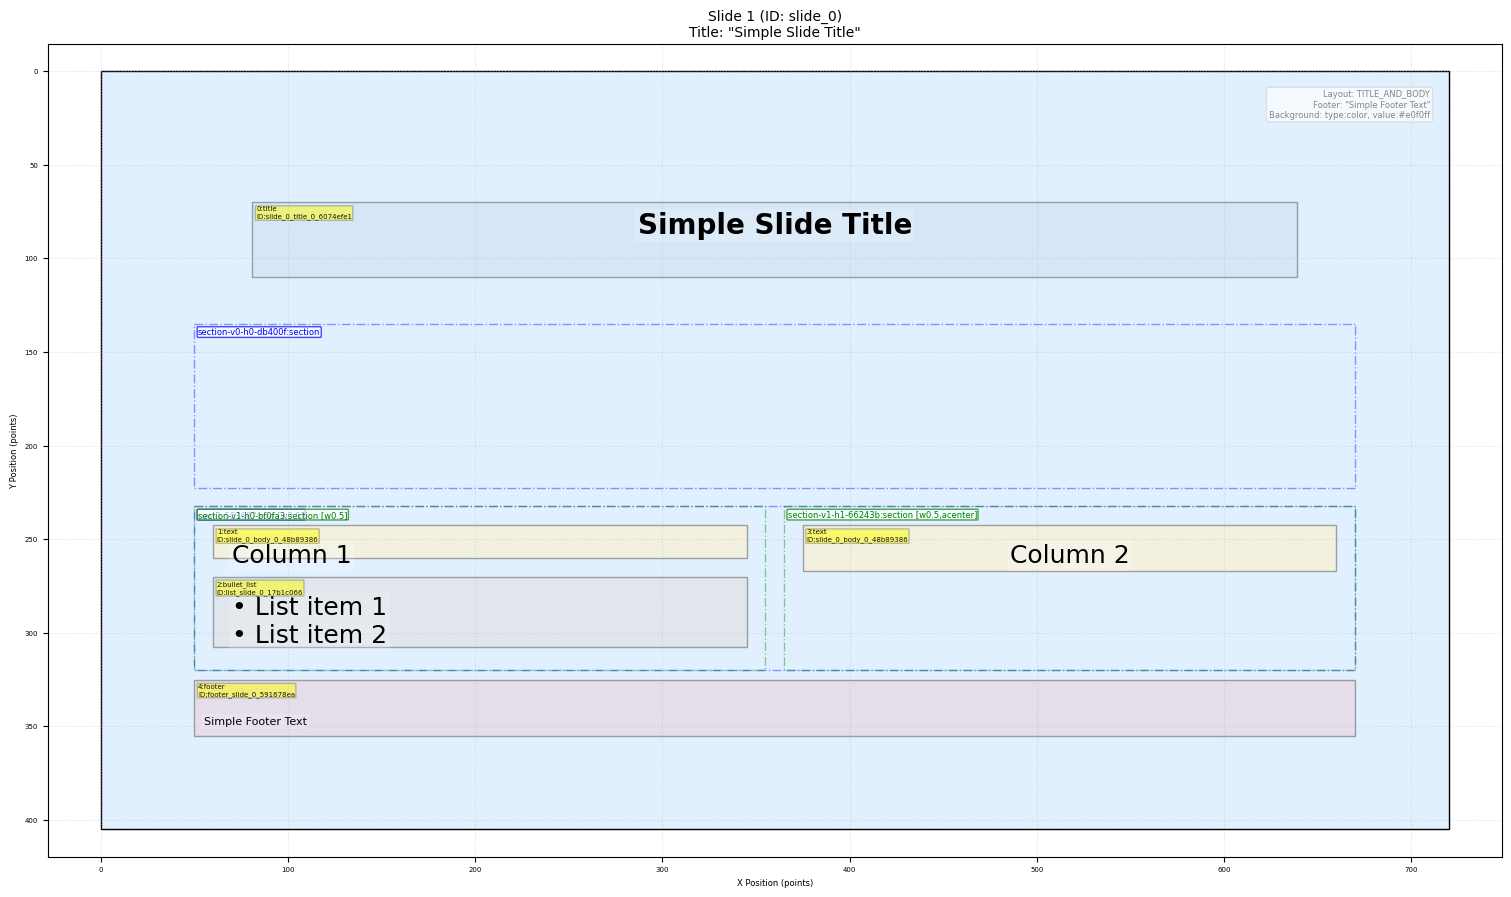

In [12]:
visualizer = SlideVisualizer()

# Visualize the illustrative slide from the deck_after_layout_illustrative
if deck_after_layout_illustrative.slides:
    visualizer.visualize(
        deck_after_layout_illustrative.slides[0],
        scale_factor=1.0,
    )
else:
    print("No slides to visualize.")

**Explanation & Observations (Visualization of Illustrative Example):**

* The plot shows the bounding boxes for each element on the slide.
* You should see the title, the first paragraph, and then the two columns side-by-side.
* Within the columns, the respective elements (list, image, text) are shown.
* Dashed lines indicate the calculated boundaries of the sections and subsections.
* This visualization is a crucial step for quickly verifying the `LayoutManager`'s output.


## 7. API Request Generation (`ApiRequestGenerator`)

The final internal stage is to convert the fully laid-out `Deck` object into Google Slides API `batchUpdate` requests. This is handled by `ApiRequestGenerator`.

- **Input:** Takes the `Deck` object (which includes slides with positioned and sized `Elements` and `Sections`).
- **Process:**
    - For each `Slide`, it generates a `createSlide` request.
    - For each `Element` on the slide, it calls an element-specific builder method (e.g., `_generate_text_element_requests`) to create API requests for creating shapes (`createShape`), inserting text (`insertText`), applying styles (`updateTextStyle`, `updateParagraphStyle`), creating images (`createImage`), tables (`createTable`), etc.
    - `position` and `size` attributes are converted into API-specific `Dimension` and `AffineTransform` objects.
- **Output:** A list of "batches," where each batch (a dictionary) typically corresponds to one slide and contains a list of individual API request objects.


In [10]:
api_request_generator = ApiRequestGenerator()

# Use the deck_after_layout_illustrative from the layout step
api_batches_illustrative = []
if deck_after_layout_illustrative.slides:
    print(f"--- Generating API Requests for Illustrative Deck ({len(deck_after_layout_illustrative.slides)} slide(s)) ---")
    placeholder_presentation_id = "ILLUSTRATIVE_PLACEHOLDER_ID"

    api_batches_illustrative = api_request_generator.generate_batch_requests(
        deck_after_layout_illustrative, placeholder_presentation_id
    )

    print(f"\n--- Summary of Generated Batches (Illustrative) ---")
    print(f"Total batches: {len(api_batches_illustrative)}")
    for i, batch in enumerate(api_batches_illustrative):
        print(f"  Batch {i+1}: For Presentation ID '{batch.get('presentationId')}', #Requests: {len(batch.get('requests', []))}")
        if batch.get("requests"):
            # Show a snippet of the first few request types in the batch
            request_types_summary = [list(req.keys())[0] for req in batch['requests'][:3]]
            print(f"    First few request types: {request_types_summary}...")
else:
    print("No slides in deck_after_layout_illustrative to generate requests for.")

# Optionally, print the full JSON for the first batch to see details
# if api_batches_illustrative:
# print("\n--- Full JSON for First Batch (Illustrative) ---")
# print(json.dumps(api_batches_illustrative[0], indent=2, default=enhanced_json_default_for_layout))


2025-05-14 14:15:35,489 - markdowndeck.api.api_generator - INFO - Generated 1 batch requests


--- Generating API Requests for Illustrative Deck (1 slide(s)) ---

--- Summary of Generated Batches (Illustrative) ---
Total batches: 1
  Batch 1: For Presentation ID 'ILLUSTRATIVE_PLACEHOLDER_ID', #Requests: 13
    First few request types: ['createSlide', 'updatePageProperties', 'insertText']...


**Explanation & Observations (ApiRequestGenerator with Illustrative Example):**

* `api_batches_illustrative` will contain one batch of requests for our single illustrative slide.
* **Requests Breakdown (Conceptual for the illustrative slide):**
    * `createSlide`: Defines the slide itself, its layout reference.
    * `updatePageProperties`: For the `[background=#e0f0ff]` directive.
    * Requests for the title element (e.g., `createShape`, `insertText`, `updateParagraphStyle` for centering).
    * Requests for the first paragraph (e.g., `createShape`, `insertText`, and `updateTextStyle` for bold/italic).
    * *No direct requests for the "row" section itself*, but its geometry influenced the element positioning within its columns.
    * For "Column 1":
        * `createShape` / `insertText` for "## Column 1".
        * `createShape` / `insertText` / `createParagraphBullets` for the list.
    * For "Column 2":
        * `createShape` / `insertText` for "## Column 2".
        * `createImage` for the placeholder image.
        * `createShape` / `insertText` for "Centered caption." with paragraph centering.
    * `insertText` for the footer (likely into a predefined footer placeholder if the chosen slide layout has one, or a created shape).
    * Requests to add speaker notes.
* Each request includes `objectId`s, `size`, `transform`, text content, and styling information, all derived from the processed `Slide` and `Element` models.
* This structure is ready to be sent to the Google Slides API.


## ✅ Explanatory Walkthrough Conclusion

This notebook has demonstrated the core pipeline of the `markdowndeck` library using a simple, illustrative example. We've seen how raw Markdown is progressively transformed:

1.  **Slides** are extracted.
2.  Slide content is parsed into **Sections** (vertical rows and horizontal columns).
3.  **Directives** within sections are parsed and applied.
4.  Markdown content within sections is converted into specific **Element models** (Text, List, Image, etc.), capturing inline formatting.
5.  The **LayoutManager** calculates precise `position` and `size` for all sections and elements.
6.  Finally, the **ApiRequestGenerator** translates these structured and laid-out models into Google Slides API requests.

This step-by-step process allows MarkdownDeck to manage the complexity of generating well-structured and precisely laid-out presentations. For diagnosing issues with more complex inputs or specific features, please refer to the "Diagnostic Data Transformation & Testing" notebook.